# CITE-seq Sample Supervision and Hyperparameter Grid Search

```{note}
This notebook is a sample of what our applications chapter will look like when we fully release it. We're working hard on compiling all of our results to share with you!
```

In this short notebook, we'll examine how sample level alignment can produce meaningful coupling matrices (which we omitted in our standard AGW tutotial), as well as how grid search can help to refine our results. We used this exact notebook when generating figures for our most recent applications paper. While a 1-1 sample mapping is not always realistic between feature domains, we explore in our PBMC cell type alignment notebook how this might be more applicable in a real setting. However, this particular example validates the ability of SCOT+ to uncover biologically understood relationships.

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a Solver object mean, try our setup tutorial for getting used to using the tool.

If you are looking for more detail on what the parameters of the alignment do in practice, start by visiting our UGW, UCOOT, fused formulation tutorials. We will draw on all of these when examining AGW.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you want to understand how to use AGW more generally, visit our AGW tutorial.
```

### Preprocessing

As usual, we set up PyTorch:

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.1.0
CUDA available: False
CUDA version: None
CUDNN version: None


To begin, we will load in our preprocessed data, as usual (see AGW tutorial).

In [2]:
%%capture
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, FOSCTTM
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

adt_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
rna_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
adt_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
rna_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(adt_raw.shape[1])]

From here, we can load our data into usable DataFrames, as in prior tutorials.

In [3]:
# l2 normalization of both datasets, which we found to help with single cell applications
adt = pd.DataFrame(normalize(adt_raw.X.transpose()))
rna = pd.DataFrame(normalize(rna_raw.X.transpose()))

# annotation of both domains
adt.index, adt.columns = samp_labels, adt_feat_labels
rna.index, rna.columns = samp_labels, rna_feat_labels

In order to keep our objective in mind, let's look at the UMAP/PCA of each domain pre-alignment once again:

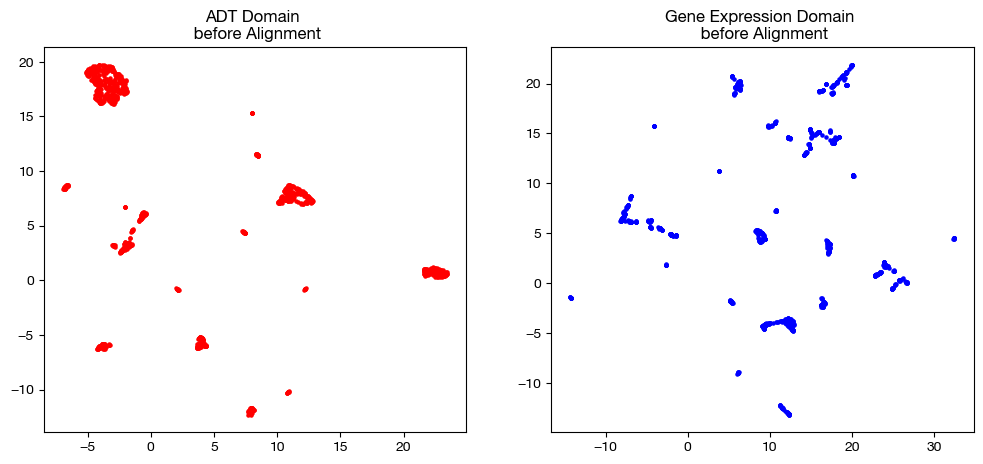

In [4]:
# we fit these objects now, and use them to transform our aligned data later on
adt_um = umap.UMAP(random_state=0, n_jobs=1)
rna_um = umap.UMAP(random_state=0, n_jobs=1)

adt_um.fit(adt.to_numpy())
rna_um.fit(rna.to_numpy())

original_adt_um=adt_um.transform(adt.to_numpy())
original_rna_um=rna_um.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(original_rna_um[:,0], original_rna_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

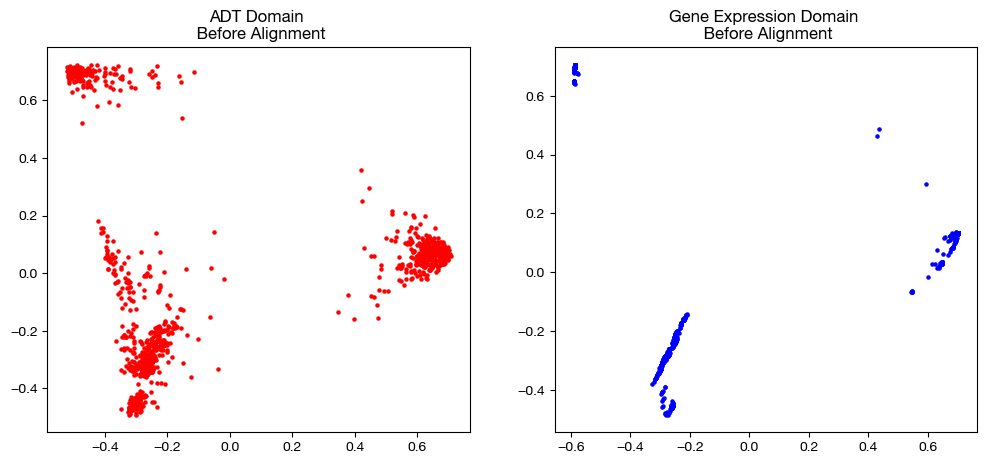

In [5]:
from sklearn.decomposition import PCA

# again, we fit these now so that we can transform our aligned data later on
adt_pca=PCA(n_components=2)
rna_pca=PCA(n_components=2)

adt_pca.fit(adt.to_numpy())
rna_pca.fit(rna.to_numpy())

original_adt_pca=adt_pca.transform(adt.to_numpy())
original_rna_pca=rna_pca.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n Before Alignment")
ax2.scatter(original_rna_pca[:,0], original_rna_pca[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n Before Alignment")
plt.show()

### Sample Level Supervision

Just as in our feature level supervision example in the AGW tutorial except for samples, we initialize $\beta$ and $D$ such that transport between corresponding samples incurs less cost than transport across samples. Note that we are adding the term $\beta \langle P, D \rangle$ to our cost function by passing in nonzero $\beta$ and $D$.

```{note}
Remember to always take a look at your local cost matrices before assigning beta, as your supervision should be relative to the magnitude of the costs the algorithm is applying.
```

In [10]:
# knn connectivity distance
D_adt_knn, D_rna_knn = torch.from_numpy(compute_graph_distances(adt, n_neighbors=110, mode='connectivity').astype('float32')).to(device), torch.from_numpy(compute_graph_distances(rna, n_neighbors=110, mode='connectivity').astype('float32')).to(device)

In [23]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3, device=device)

D_samp = torch.from_numpy(-1*np.identity(1000, dtype='float32') + np.ones((1000, 1000), dtype='float32')).to(device)

pi_samp_unsup, _, pi_feat_unsup = scot.agw(rna, adt, D_rna_knn, D_adt_knn, alpha=0.2, eps=5e-3, verbose=False)

pi_samp_medsup, _, pi_feat_medsup = scot.agw(rna, adt, D_rna_knn, D_adt_knn, alpha=0.2, eps=5e-3, beta=(1e-2, 0), D=(D_samp, 0), verbose=False)

pi_samp_fullsup, _, pi_feat_fullsup = scot.agw(rna, adt, D_rna_knn, D_adt_knn, alpha=0.2, eps=5e-3, beta=(2e-1, 0), D=(D_samp, 0), verbose=False)

In [24]:
aligned_rna_unsup = get_barycentre(adt, pi_samp_unsup)
aligned_rna_medsup = get_barycentre(adt, pi_samp_medsup)
aligned_rna_fullsup = get_barycentre(adt, pi_samp_fullsup)

We can score and visualize:

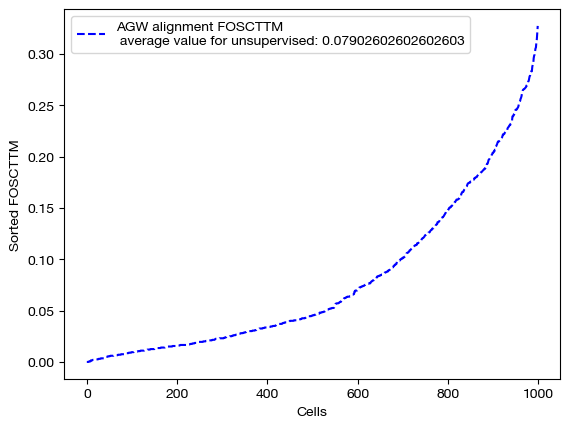

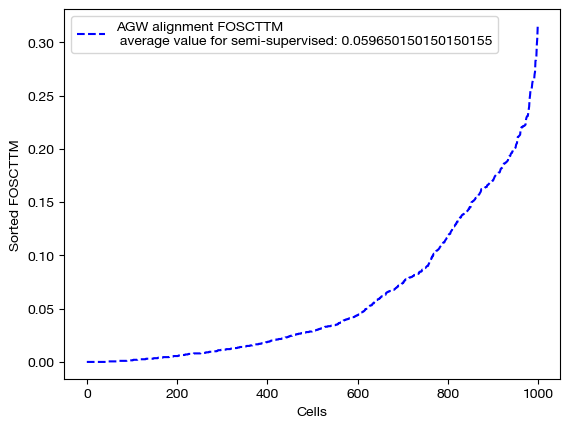

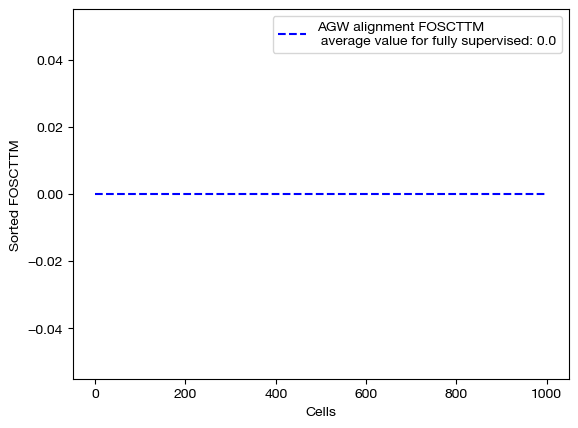

In [25]:
for aligned_rna, mode in [(aligned_rna_unsup, 'unsupervised'), (aligned_rna_medsup, 'semi-supervised'), (aligned_rna_fullsup, 'fully supervised')]:
    fracs = FOSCTTM(adt, aligned_rna.numpy())
    legend_label="AGW alignment FOSCTTM \n average value for {0}: ".format(mode)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

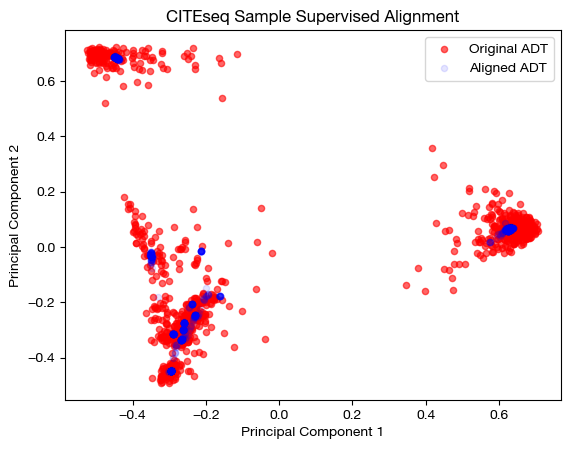

In [26]:
aligned_rna_pca=adt_pca.transform(aligned_rna_unsup.numpy())

# plotting aligned domain over original
plt.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=20, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=20, alpha=0.1, label="Aligned ADT")
plt.legend()
plt.title("CITEseq Sample Supervised Alignment")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

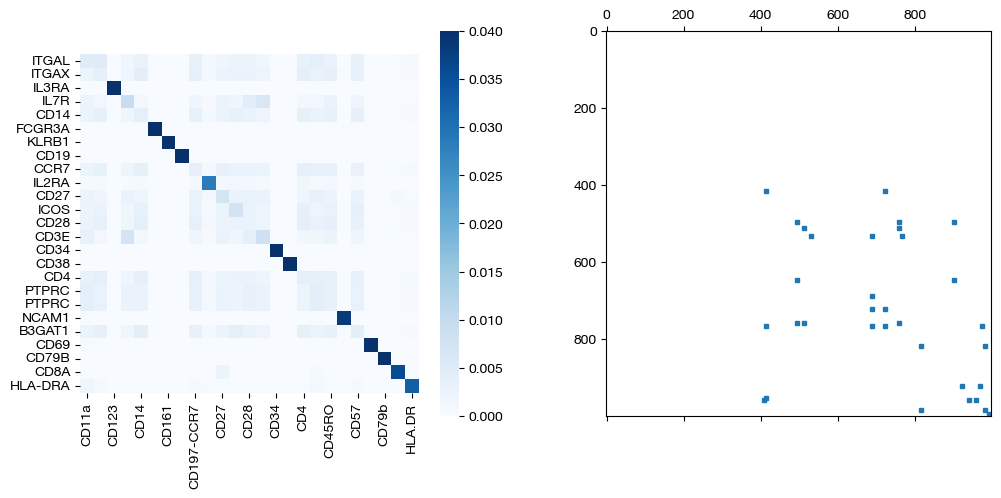

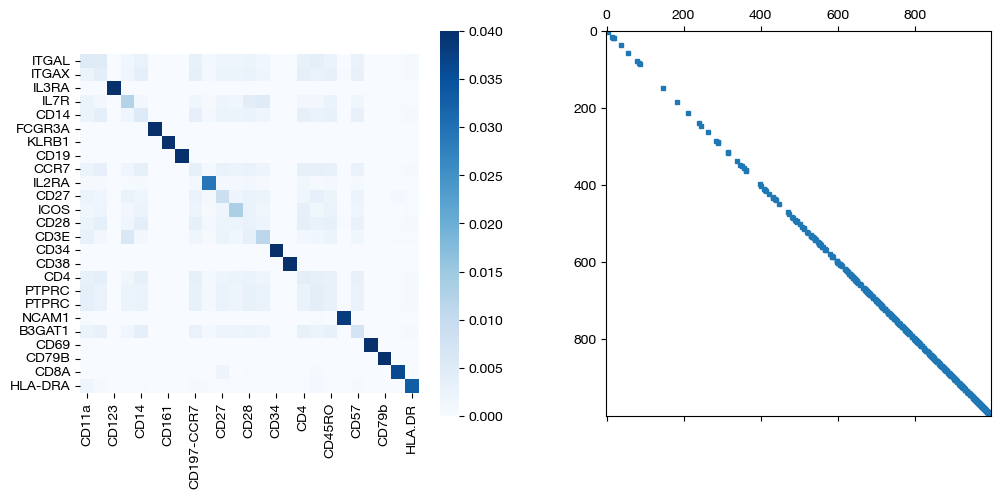

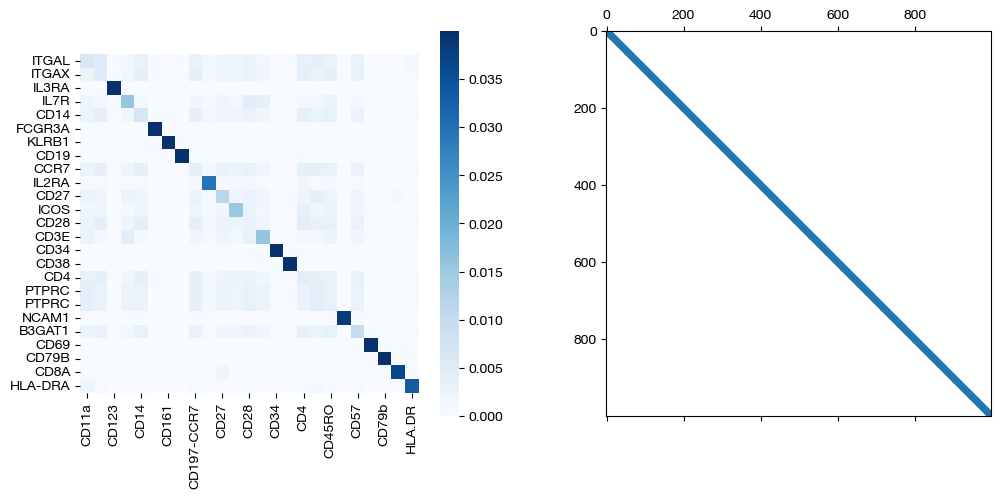

In [27]:
for pi_feat, pi_samp, mode in [(pi_feat_unsup, pi_samp_unsup, 'unsupervised'), (pi_feat_medsup, pi_samp_medsup, 'some supervision'), (pi_feat_fullsup, pi_samp_fullsup, 'full supervision')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

As we can see, sample level supervision greatly aids feature level alignment, as expected!

### Grid Search

Since even the unsupervised alignment here is fairly high quality, we can do a grid search to refine our results. Specifically, we search over $\epsilon$ and $\alpha$:

In [29]:
# we comment this code out to save time, but if you run it, you should find 
# that the argmin parameters are eps=, alpha=.
min_score = 1
argmin_params = None
results_list = []
for eps in np.linspace(5e-4, 1e-2, 8):
    for alpha in np.linspace(0.05, 0.2, 8):
        print(f"Working on {alpha}, {eps}...")
        pi_samp_unsup, _, pi_feat_unsup = scot.agw(rna, adt, D_rna_knn, D_adt_knn, alpha=alpha, eps=eps, verbose=False)
        aligned_rna_unsup = get_barycentre(adt, pi_samp_unsup)
        fracs = FOSCTTM(adt, aligned_rna_unsup.numpy())
        if np.mean(fracs) < min_score:
            min_score = np.mean(fracs)
            argmin_params = (alpha, eps)
        print(alpha, eps, np.mean(fracs))
        results_list.append((pi_samp_unsup, pi_feat_unsup, alpha, eps, np.mean(fracs)))
min_score, argmin_params = (0.07795295295295296, (0.05, 0.0031622776601683794))
min_score, argmin_params

Working on 0.05, 0.0005...
0.05 0.0005 0.07752302302302302
Working on 0.07142857142857144, 0.0005...
0.07142857142857144 0.0005 0.08942392392392393
Working on 0.09285714285714286, 0.0005...
0.09285714285714286 0.0005 0.09066416416416416
Working on 0.1142857142857143, 0.0005...
0.1142857142857143 0.0005 0.11032882882882881
Working on 0.13571428571428573, 0.0005...
0.13571428571428573 0.0005 0.11032032032032033
Working on 0.15714285714285717, 0.0005...
0.15714285714285717 0.0005 0.11025875875875876
Working on 0.1785714285714286, 0.0005...
0.1785714285714286 0.0005 0.10882082082082083
Working on 0.2, 0.0005...
0.2 0.0005 0.10978528528528528
Working on 0.05, 0.0018571428571428571...
0.05 0.0018571428571428571 0.09776076076076075
Working on 0.07142857142857144, 0.0018571428571428571...
0.07142857142857144 0.0018571428571428571 0.09785985985985986
Working on 0.09285714285714286, 0.0018571428571428571...
0.09285714285714286 0.0018571428571428571 0.0773108108108108
Working on 0.114285714285714

(0.07795295295295296, (0.05, 0.0031622776601683794))

In [32]:
[(x[2], x[3], x[4]) for x in sorted(results_list, key=lambda x: x[4])]

[(0.09285714285714286, 0.0018571428571428571, 0.0773108108108108),
 (0.13571428571428573, 0.0018571428571428571, 0.07734634634634635),
 (0.1142857142857143, 0.0018571428571428571, 0.07737637637637639),
 (0.05, 0.0005, 0.07752302302302302),
 (0.2, 0.0018571428571428571, 0.07776326326326327),
 (0.1785714285714286, 0.0018571428571428571, 0.07782232232232232),
 (0.15714285714285717, 0.0018571428571428571, 0.07788038038038039),
 (0.05, 0.0032142857142857142, 0.07801601601601602),
 (0.07142857142857144, 0.0032142857142857142, 0.07818018018018018),
 (0.09285714285714286, 0.0032142857142857142, 0.0781941941941942),
 (0.1142857142857143, 0.0032142857142857142, 0.0781951951951952),
 (0.2, 0.0032142857142857142, 0.07821071071071072),
 (0.13571428571428573, 0.0032142857142857142, 0.07824024024024025),
 (0.1785714285714286, 0.0032142857142857142, 0.07825575575575576),
 (0.15714285714285717, 0.0032142857142857142, 0.0783168168168168),
 (0.05, 0.004571428571428572, 0.07863713713713713),
 (0.114285714

We can replicate and examine the resulting best alignment:

In [21]:
pi_samp, _, pi_feat = scot.agw(rna, adt, D_rna_knn, D_adt_knn, alpha=argmin_params[0], eps=argmin_params[1], nits_gw=5, verbose=False)
aligned_rna = get_barycentre(adt, pi_samp)

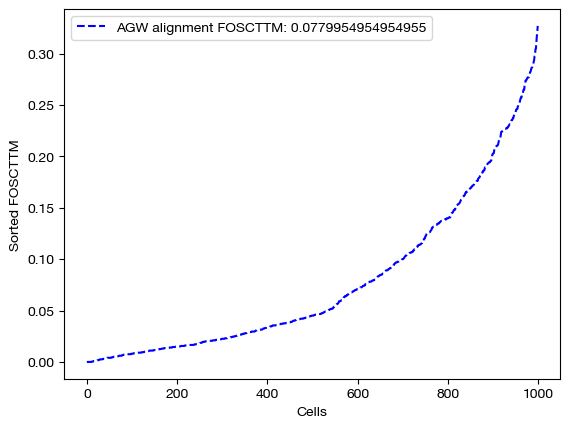

In [22]:
fracs = FOSCTTM(adt, aligned_rna.numpy())
legend_label="AGW alignment FOSCTTM: ".format(mode)+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

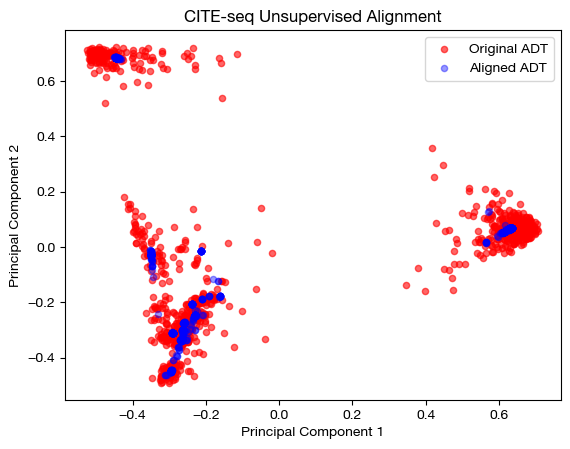

In [94]:
aligned_rna_pca=adt_pca.transform(aligned_rna.numpy())

# plotting aligned domain over original
plt.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=20, alpha=0.6, label="Original ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=20, alpha=0.4, label="Aligned ADT")
plt.legend()
plt.title("CITE-seq Unsupervised Alignment")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

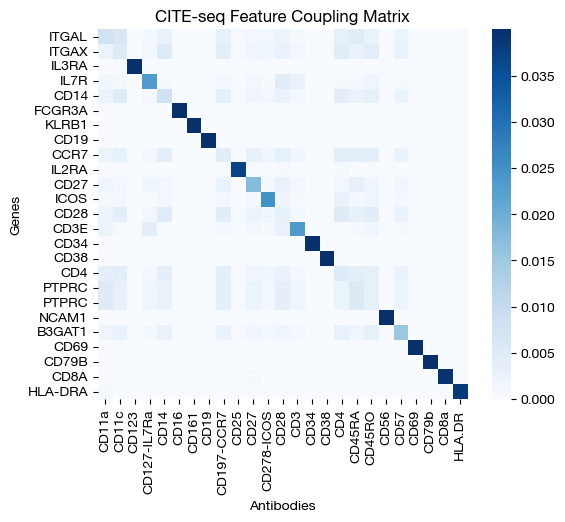

In [96]:
sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), cmap='Blues', square=True)
plt.title("CITE-seq Feature Coupling Matrix")
plt.xlabel("Antibodies")
plt.ylabel("Genes")
plt.show()

The above grid-search helped us find the best parameters for this particular setting. In general, if you have any criteria on which to evaluate your alignments (e.g., cell type information), grid search is a good idea.

Now, we recommend moving onto other applications tutorials, such as our cell type supervision tutorial or our unbalanced PBMC tutorial.